In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('pdb_data_seq_20.csv')
df_char = pd.read_csv('pdb_data_no_dups_20.csv')
print('Datasets have been loaded...')

Datasets have been loaded...


C:\Users\asus\AppData\Local\Temp\ipykernel_3088\3584225734.py:11: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_seq = pd.read_csv('pdb_data_seq_20.csv')
C:\Users\asus\AppData\Local\Temp\ipykernel_3088\3584225734.py:12: DtypeWarning: Columns (0,1,2,3,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_char = pd.read_csv('pdb_data_no_dups_20.csv')


In [2]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [4]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Dec,BLOOD COAGULATION,APRLPQCQGDDQEKCLCNKDECPPGQCRFPRGDADPYCE


In [5]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

38926 is the number of rows in the joined dataset


In [6]:
# Check NA counts
model_f.isnull().sum()

classification    0
sequence          1
dtype: int64

In [7]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

38925 is the number of proteins that have a classification and sequence


HYDROLASE                         4657
OXIDOREDUCTASE                    4015
TRANSFERASE                       3587
LYASE                             1634
IMMUNE SYSTEM                     1348
                                  ... 
REVERSE TRANSCRIPTASE                1
CHITIN-BINDING                       1
ISOMERASE/TRANSFERASE                1
ACETYLTRANSFERASE                    1
OXIDOREDUCTASE (H2O2 ACCEPTOR)       1
Name: classification, Length: 1533, dtype: int64


C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


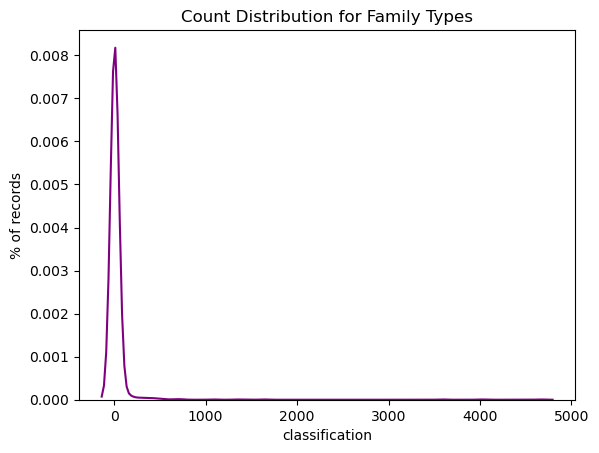

In [8]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [9]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE' 'OXIDOREDUCTASE' 'TRANSFERASE' 'LYASE' 'IMMUNE SYSTEM'
 'HYDROLASE/HYDROLASE INHIBITOR']
16326 is the number of records in the final filtered dataset


In [10]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zgar', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
# # 4). ------ Machine Learning Models ------
# # Support vector machine model
# # Make a prediction dictionary to store accuracys
prediction = dict()

from sklearn import svm
model = svm.SVC()
model.fit(X_train_df, y_train)
SVM_pred = model.predict(X_test_df)
prediction["Support"] = accuracy_score(SVM_pred, y_test)
print( prediction['Support'])

0.9066135946111451


In [12]:
prediction = dict()

# # Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.9246785058175138


In [13]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_df,y_train)
ADA_pred = model.predict(X_test_df)
prediction["Adaboost"] = accuracy_score(ADA_pred , y_test)
print(prediction["Adaboost"])

0.3643600734843846


In [14]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_df,y_train)
RFC_pred = model.predict(X_test_df)
prediction["Random"] = accuracy_score(RFC_pred , y_test)
print(prediction["Random"])


0.9467238211879976


In [15]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train_df,y_train)
DTC_pred = model.predict(X_test_df)
prediction["D"] = accuracy_score(DTC_pred , y_test)
print(prediction["D"])

0.9295774647887324


In [16]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_df,y_train)
LGR_pred = model.predict(X_test_df)
prediction["Regression"] = accuracy_score(LGR_pred , y_test)
print(prediction["Regression"])

0.9433557868952848


C:\Users\asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_df,y_train)
KNN_pred = model.predict(X_test_df)
prediction["KNeighborsClassifier"] = accuracy_score(KNN_pred , y_test)
print(prediction["KNeighborsClassifier"])

0.812614819350888


C:\Users\asus\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [18]:
# print(types[3])
# print(types[38])

LYASE


IndexError: index 38 is out of bounds for axis 0 with size 6

<AxesSubplot:>

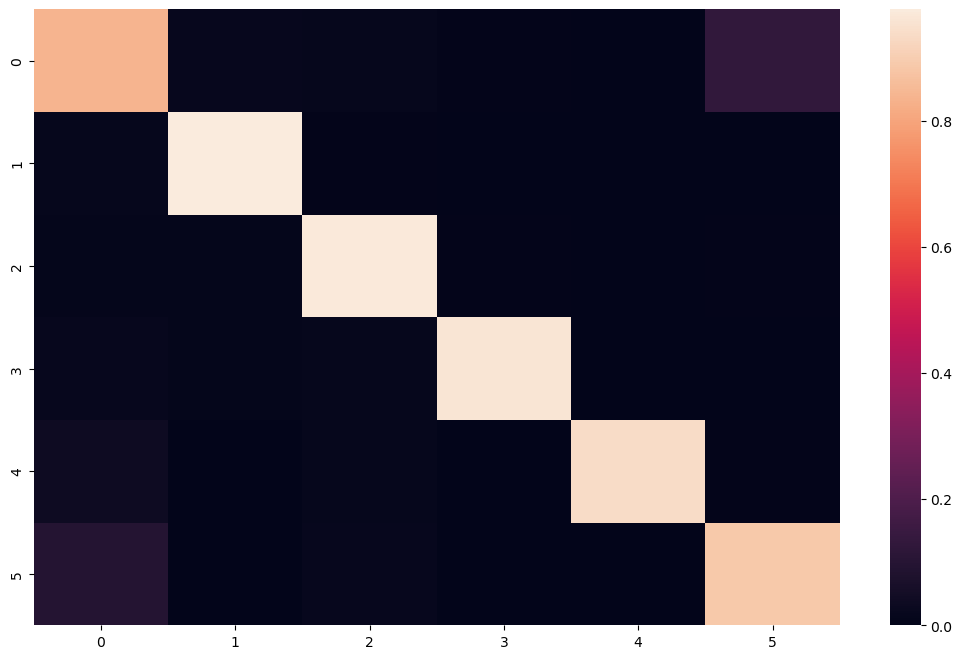

In [19]:
#----- Plot Confusion Matrix for NB -----

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

In [20]:
#Print F1 score metrics
print(classification_report(y_test, NB_pred, target_names = types))

                               precision    recall  f1-score   support

                    HYDROLASE       0.94      0.84      0.88       918
               OXIDOREDUCTASE       0.61      0.89      0.72       215
                  TRANSFERASE       0.98      0.94      0.96       274
                        LYASE       0.96      0.96      0.96       325
                IMMUNE SYSTEM       0.97      0.98      0.97       814
HYDROLASE/HYDROLASE INHIBITOR       0.96      0.97      0.97       720

                     accuracy                           0.92      3266
                    macro avg       0.90      0.93      0.91      3266
                 weighted avg       0.93      0.92      0.93      3266

